In [1]:
#必要なライブラリをimport
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
import openpyxl
from collections import deque
import time
import random
import copy
import csv
from concurrent.futures import ThreadPoolExecutor
import itertools

#pymoo
from pymoo.util.misc import stack
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
#from pymoo.factory import get_termination 非推奨
from pymoo.termination import get_termination
from pymoo.util import plotting

In [2]:
#1つのファジィ制御のクラス(設計書)
class fuzzy:
    #ファジィルール，K群，集合の数(前件，後件)，メンバーシップ関数のタイプ(前件，後件)
    def __init__(self,rule,Ki,set_nums,set_types):
        self.rule = rule
        self.Ki,self.Kw = self.update_Klist(Ki,set_nums,set_types)
        self.set_nums = set_nums
        self.set_types = set_types
        self.si_set = self.slope_intercept_set(self.Ki,self.Kw,set_types)
        
    def making_widths_step(self,one_Ki,set_type):
        one_Kw = []
        sum_k = 0
        one_Kw.append(sum_k)
        if set_type==0:
            for k in one_Ki:
                sum_k += k
                one_Kw.append(sum_k)
        elif set_type==1 or set_type==-1:
            for k in one_Ki:
                sum_k += k
                one_Kw.append(sum_k)
        return one_Kw
    
    def update_Klist(self,Kis,set_nums,set_types):
        new_Kis = []
        Kis_widths = []
        for i in range(len(Kis)):
            one_Kw = []
            set_num = set_nums[i]
            member_type = set_types[i]
            if member_type == 0:
                side_num = set_num//2
                if side_num != len(Kis[i]):
                    one_Ki = [Kis[i][0]]*side_num
                    one_Kw = self.making_widths_step(one_Ki,0)
                else:
                    one_Ki = Kis[i]
                    one_Kw = self.making_widths_step(one_Ki,0)
            elif member_type == 1:
                if set_num != len(Kis[i])+1:
                    one_Ki = [Kis[i][0]]*(set_num-1)
                    one_Kw = self.making_widths_step(one_Ki,1)
                else:
                    one_Ki = Kis[i]
                    one_Kw = self.making_widths_step(one_Ki,1)
            elif member_type == -1:
                if set_num != len(Kis[i])+1:
                    one_Ki = [Kis[i][0]]*(set_num-1)
                    one_Kw = self.making_widths_step(one_Ki,-1)
                else:
                    one_Ki = Kis[i]
                    one_Kw = self.making_widths_step(one_Ki,-1)
            new_Kis.append(one_Ki)
            Kis_widths.append(one_Kw)
        return new_Kis,Kis_widths
    
    def slope_intercept_set(self,Ki,Kw,set_types):
        sl_list = []
        #Kw = copy.deepcopy(Kw)
        #右側
        for k,w,t in zip(Ki,Kw,set_types):
            num_set = len(k)
            k_arr = np.array(k)
            for i in range(num_set):
                w.insert(0,-w[-(num_set-i)])
            w_arr = np.array(w)
            sr_arr=1/k_arr
            sl_arr=-1*sr_arr
            ir_arr=np.flip(w_arr[1:num_set+1]).copy()*sr_arr
            il_arr=-w_arr[num_set+1:]*sl_arr
            r_arr = np.stack([sr_arr, ir_arr],1)
            l_arr = np.stack([sl_arr, il_arr],1)
            union_arr_right = np.stack([r_arr,l_arr],1)
            if t==1:
                sl_list.append(union_arr_right)
            else:
                union_arr_left = np.flip(union_arr_right,(0,1)).copy()
                union_arr_left[:,:,0] = -1*union_arr_left[:,:,0]
                if t==-1:
                    sl_list.append(union_arr_left)
                else:
                    union_all = np.vstack([union_arr_left,union_arr_right])
                    sl_list.append(union_all)
        return sl_list
    
    def fuzzy_set(self,i,value,si):
        grade = si[0] * value + si[1]
        result = [i,grade]
        return result
    
    def fuzzy_ante(self,x,k,Kw,set_num,set_type,si_set):
        start_no = 0
        end_no = set_num - 1
        if set_type == 1:
            start_no = set_num-1
            end_no = start_no*2
        value_sets = []
        if x <= Kw[start_no]:
            value_sets.append([0,1.0])
        elif x >= Kw[end_no]:
            value_sets.append([end_no-start_no,1.0])
        for i in range(start_no,end_no):
            if Kw[i] < x and x < Kw[i+1]:
                value_sets.append(self.fuzzy_set(i-start_no, x, si_set[i-start_no][1]))
                value_sets.append(self.fuzzy_set(i-start_no + 1, x,si_set[i-start_no][0]))
                break
            elif x == Kw[i]:
                value_sets.append([i-start_no,1.0])
                break
            elif x == Kw[i+1]:
                value_sets.append([i-start_no+1,1.0])
                break
        return  value_sets
    
    def fuzzy_min_case(self,antes ,x_num):
        outs=[]
        if x_num == 2:
            for j in range(len(antes[0])):
                for i in range(len(antes[1])):
                    outs.append(self.fuzzy_min2(antes[0][j], antes[1][i]))
        
        elif x_num == 3:
            for k in range(len(antes[0])):
                for j in range(len(antes[1])):
                    for i in range(len(antes[2])):
                        outs.append(self.fuzzy_min3(antes[0][k], antes[1][j], antes[2][i]))
        return outs
    
    def fuzzy_min2(self,ant1,ant2):
        out_Set = self.rule[ant2[0]][ant1[0]]
        if ant1[1] >= ant2[1]:
            out_Value = ant2[1]
        elif ant1[1] < ant2[1]:
            out_Value = ant1[1]
        out_set = [out_Set,out_Value]
        return out_set
    
    def fuzzy_min3(self,ant3,ant2,ant1):
        out_Set = self.rule[ant3[0]][ant2[0]][ant1[0]]
        if (ant1[1] <= ant2[1] and ant1[1] <= ant3[1]):
            out_Value = ant1[1]
        elif ant2[1] <= ant1[1] and ant2[1] <= ant3[1]:
            out_Value = ant2[1]
        elif ant3[1] <= ant1[1] and ant3[1] <= ant2[1]:
            out_Value = ant3[1]
        out_set = [out_Set,out_Value]
        return out_set
    
    def fuzzy_cons1(self,outs):
        set_num = self.set_nums[-1]
        set_type = self.set_types[-1]
        start_no = 0
        end_no = set_num
        if set_type == 1:
            start_no = set_num-1
            end_no = start_no*2+1
        out = [0] * set_num
        Kw_last = copy.deepcopy(self.Kw[-1])
        for i in range(len(outs)):
            if out[outs[i][0]] != 0:
                if outs[i][1] > out[outs[i][0]]:
                    out[outs[i][0]] = outs[i][1]
            else:
                out[outs[i][0]] = outs[i][1]            
        deno = 0
        nume = 0
        for i in range(start_no,end_no):
            deno += out[i-start_no]
            nume += out[i-start_no] * Kw_last[i]
        output = nume / deno
        return output
    
    def fuzzy_calc(self,x):
        antes = []
        outs = []
        for i in range(len(x)):
            antes.append(self.fuzzy_ante(x[i], self.Ki[i],self.Kw[i], self.set_nums[i],self.set_types[i],self.si_set[i]))
        outs = self.fuzzy_min_case(antes,len(x))
        output_speed = self.fuzzy_cons1(outs)
        return output_speed

In [3]:
#[0,0]と任意の2点の軌道(評価用)
def lm_pos(r_max):
    r = np.array([random.uniform(0, r_max) for i in range(2)])
    th = np.array([random.uniform(0,2*math.pi) for i in range(2)])
    x = r*np.cos(th)
    y = r*np.sin(th)
    lm2 = np.stack([x, y],axis=1)
    return lm2

def lms_produce(r_max,num):
    lms = np.array([lm_pos(r_max) for i in range(int(num))])
    return lms

def pos_conversion(pos,sp,ep):
    x,y,theta = pos
    ep = ep-sp
    delth = math.atan2(ep[1],ep[0])
    R = np.array([[np.cos(-delth), -np.sin(-delth)],
                  [np.sin(-delth), np.cos(-delth)]])
    v = (x-sp[0],y-sp[1])
    new_pos = np.dot(R,v)
    new_pos = np.append(new_pos, theta-delth)
    return new_pos

In [4]:
def pop_No_update(res,no):
    if no!=None:
        pop_no = np.argmin(res.F[:,no])
    else:
        pop_no=np.argmin(np.sum(res.F,1))
    print("pop_update -> <POP {}>".format(pop_no))
    return pop_no

def fuzzy_control_new_set(problem,pop_no):
    if pop_no != None:
        pop = res.pop
        genes = pop[pop_no].get("X")
        genes = genes.tolist()
        if problem.ruch_count1 or problem.ruch_count2 == 1:
            Kis = problem.Ks_divi_list(genes[0:-(problem.ruch_count1+problem.ruch_count2)],problem.divi_list)
            ruge_list = genes[len(genes[0:-(problem.ruch_count1+problem.ruch_count2)]):]
            problem.obj_control.fuzzy_rule1 = problem.rule_changer(problem.obj_control.fuzzy_rule1,problem.ruch_count1,
                                                        problem.ruch_countarr1,ruge_list[0:problem.ruch_count1])
            problem.obj_control.fuzzy_rule2 = problem.rule_changer(problem.obj_control.fuzzy_rule2,problem.ruch_count2,
                                                        problem.ruch_countarr2,ruge_list[problem.ruch_count1:problem.ruch_count1+problem.ruch_count2])
        else:
            Kis = problem.Ks_divi_list(genes,problem.divi_list)            
    
    else:
        Kis = [[0.781],[308],[147],[106],[0.715],[188],[187]]
        out_level1 = 3
        fuzzy_rule1 = np.array([[[0,1,2],[0,1,1],[0,0,0]],[[1,2,2],[1,1,1],[0,0,0]],[[2,2,2],[1,1,1],[0,0,0]]])
        set_types1 = [1,1,1,-1]
        out_level2 =7
        fuzzy_rule2 = np.array([[0,0,0,1,2,3,4],[0,0,1,1,2,3,4],[0,1,1,2,3,4,5],[0,1,2,3,4,5,6],[1,2,3,4,5,5,6],[2,3,4,5,5,6,6],[2,3,4,5,6,6,6]])
        set_types2 = [0,0,0]
        problem.obj_control = obj_func(fuzzy_rule1 = fuzzy_rule1,set_types1 = set_types1, out_level1=out_level1,
                                 fuzzy_rule2 = fuzzy_rule2,set_types2 = set_types2,out_level2=out_level2)
    return problem,Kis

def drive_test(problem,Kis,fpos,lms,tim):
    Obj = problem.obj_control
    Obj.time_limit = tim
    Obj.fpos = fpos
    Obj.fuzzy_produce(Kis,lms)
    Obj.move_trial()

    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("X",fontsize=10)
    ax.set_ylabel("Y",fontsize=10)
    ax.scatter(0,0,s=50,marker="o",label="landmarks",color="cyan")

    count  = 0
    for lm in lms: #静止体の描画1
        ax.scatter(lm[0],lm[1],s=50,marker="*",label="landmarks",color="orange")
        ax.text(lm[0],lm[1],"id:"+str(count),fontsize=10)
        count +=1
    
    plt.scatter(Obj.li1,Obj.li2,s=1,marker="o")
    plt.show()
    return [Obj.li1,Obj.li2,Obj.li3]

In [5]:
def print_obj_func(problem,res,order):
    if order==0:
        pop=res.pop
        obj_values = pop.get("F")
    else:
        obj_values = res.F
    #グラフ表示(2次元)
    plt.rcParams["figure.figsize"] = (10,3)
    plt.subplot(131)
    for a,b in zip(obj_values[:,0],obj_values[:,1]):
        plt.scatter(a,b)
    plt.subplot(132)
    for a,b in zip(obj_values[:,0],obj_values[:,2]):
        plt.scatter(a,b)
    plt.subplot(133)
    for a,b in zip(obj_values[:,1],obj_values[:,2]):
        plt.scatter(a,b)
    plt.show()
    
def member_func_print(fuzzy_obj):
    num = len(fuzzy_obj.si_set)
    y = np.array([0,1])
    for i in range(num):
        fig = plt.figure(figsize=(10,3))
        ax = fig.add_subplot(1, 1, 1)
        x = []
        x_1=None
        abset = fuzzy_obj.si_set[i].reshape(-1,2)
        for j in range(len(abset)):
            x_tmp = (y-abset[j][1])/abset[j][0]
            x.append(x_tmp)
        if i!=num-1:
            for one_x in x:
                ax.plot(one_x, y,color ="black")
                one_x[0]=round(one_x[0], 2)
                if one_x[0]!=x_1:
                    ax.annotate("{:.2f}".format(one_x[0]), (one_x[0], 0), size = 10, textcoords='offset points', xytext=(0,-20), ha='center', va='bottom')
                    x_1 = one_x[0]
        else:
            for one_x in x:
                ax.axvline(x=one_x[0], ymin=0, ymax=1,color="black")
                one_x[0]=round(one_x[0], 2)
                if one_x[0]!=x_1:
                    ax.annotate("{:.2f}".format(one_x[0]), (one_x[0], 0), size = 10, textcoords='offset points', xytext=(0,-20), ha='center', va='bottom')
                    x_1 = one_x[0]
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ty = fuzzy_obj.set_types[i]
        if ty==0:
            x_max = x_1
            x_min = -x_max
        elif ty==1:
            x_max = x_1
            x_min = 0
        else:
            x_min = ((y-abset[0][1])/abset[0][0])[0]
            x_max = 0
        ax.vlines(0, 0, 1,color="gray",linestyles='dotted')
        ax.hlines(y=[0, 1], xmin=x_min, xmax=x_max,color="gray",linestyles='dotted')
        
        
def print_membership(Pop,Kis):
    lms = None
    member_confirm_obj = problem.obj_control
    member_confirm_obj.fuzzy_produce(Kis,lms)
    member_func_print(member_confirm_obj.fuzzy1)
    member_func_print(member_confirm_obj.fuzzy2)

def data_to_text(fuzzy_class):
    rule = fuzzy_class.rule
    rule_arr  = copy.deepcopy(rule)
    text_data = rule_arr.tolist()
    set_types = fuzzy_class.set_types
    set_nums = fuzzy_class.set_nums
    set_set = []
    axis_set = []
    for i in range(len(set_nums)):
        axis=[]
        axis.append("ZO")
        set_type = set_types[i]
        if set_type==0:
            num = set_nums[i]//2
            for j in range(num):
                axis.append("P"+str(j))
                axis.insert(0,"N"+str(j))
        elif set_type==1:
            num = set_nums[i]-1
            for j in range(num):
                axis.append("P"+str(j))
        elif set_type==-1:
            num = set_nums[i]-1
            for j in range(num):
                axis.insert(0,"N"+str(j))
        axis_set.append(axis)
        
    set_type = set_types[-1]
    
    if len(set_nums)-1==2:
        for k in range(len(text_data)):
            for j in range(len(text_data[0])):
                value = text_data[k][j] 
                text_data[k][j] = axis_set[-1][value]
    elif len(set_nums)-1==3:
        for k in range(len(text_data)):
            for j in range(len(text_data[0])):
                for i in range(len(text_data[0][0])):
                    value = text_data[k][j][i] 
                    text_data[k][j][i] = axis_set[-1][value]
        
    return axis_set,text_data,rule_arr

def print_rule_text(fuzzy_class):
    axis_set,text_data,data = data_to_text(fuzzy_class)
    norm_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    cm = plt.get_cmap('coolwarm')
    color = cm(norm_data)
    if len(fuzzy_class.set_nums)-1==2:
        rule_2_text(text_data,axis_set,color)
    elif len(fuzzy_class.set_nums)-1==3:
        rule_3_text(text_data,axis_set,color)
    return True

def rule_2_text(text_data,axis_set,color):
    # fig準備
    fig = plt.figure(figsize=(8,1))
    ax1 = fig.add_subplot(111)

    # 表の定義
    ax1.axis('off')
    the_table = ax1.table(cellText=text_data,cellLoc="center",colWidths=[0.05]*8, colLabels=axis_set[0], rowLabels=axis_set[1],
          loc="center",cellColours=color)
    the_table.scale(2,2)
    the_table.set_fontsize(14)
    # 表示
    plt.show()
    plt.close()
    return True
    
def rule_3_text(text_data,axis_set,color):
    # fig準備
    fig = plt.figure(figsize=(10,3))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
 
    # 表の定義
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    the_table1 = ax1.table(cellText=text_data[0],cellLoc="center",colWidths=[0.05]*8, colLabels=axis_set[1], rowLabels=axis_set[2],
          loc="center",cellColours=color[0])
    the_table2 = ax2.table(cellText=text_data[1],cellLoc="center",colWidths=[0.05]*8, colLabels=axis_set[1], rowLabels=axis_set[2],
          loc="center",cellColours=color[1])
    the_table3 = ax3.table(cellText=text_data[2],cellLoc="center",colWidths=[0.05]*8, colLabels=axis_set[1], rowLabels=axis_set[2],
          loc="center",cellColours=color[2])

    the_table1.scale(4,3)
    the_table1.set_fontsize(14)
    the_table2.scale(4,3)
    the_table2.set_fontsize(14)
    the_table3.scale(4,3)
    the_table3.set_fontsize(14)
 
    # 表示
    print(axis_set[0])
    plt.show()
    plt.close()

def print_result(member_result,rule_result,obj_control,Pop,Kis):
    if rule_result:
        print_rule_text(obj_control.fuzzy1)
        print_rule_text(obj_control.fuzzy2)
    if member_result:
        print_membership(Pop,Kis)

In [6]:
#軌道追従制御のクラス(設計書)
class obj_func:
    def __init__(self,time_limit=20,time_interval=0.5,time_detail=0.1,
                 fpos=[0,0,math.pi/2],init_vo=[360,0],footsteps=5,
                 fuzzy_rule1=None,set_types1=None,out_level1=None,fuzzy_rule2=None,set_types2=None,out_level2=None,
                 lms=None,Kis=None):
        self.time_limit=time_limit #行う時間
        self.time_interval=time_interval #制御周期
        self.time_detail = time_detail #1コマの時間
        self.fpos=fpos
        self.pose = fpos
        self.init_vo = init_vo
        self.nu=init_vo[0]
        ##############ロボットの大きさ変更########################################
        self.wheel_d = 0.0665
        self.robot_width = 0.117 #左右輪の中心の間の距離(m)
        ######################################################
        self.nu_m = init_vo[0]/360*(self.wheel_d*math.pi)
        self.nur = init_vo[0]  
        self.nul = init_vo[0]
        self.omega=init_vo[1]
        self.lms = None
        self.sum_time = 0.0
        
        #記憶できる足跡数と連番初期化
        self.orbit_que = deque([np.array(fpos)for i in range(footsteps)])
        self.past_no = 0
        self.orbit_no = 0
        self.now_no = 1 #現在の目標点
        self.next_no = 2 #次の目標点
        self.no_len = 3 #目標点の数
        self.point_r = 0.1 #目標点を判定する半径の大きさ
        
        #ファジィルール設定
        self.fuzzy_rule1 = fuzzy_rule1
        self.length_ff1 = len(self.fuzzy_rule1)#theta2
        self.length_ff2 = len(self.fuzzy_rule1[0])# omega
        self.length_ff3 = len(self.fuzzy_rule1[0][0]) # distance
        self.set_nums1 = [self.length_ff1,self.length_ff2,self.length_ff3,out_level1]
        self.set_types1 = set_types1
        
        self.fuzzy_rule2 = fuzzy_rule2
        self.length_ff4 = len(self.fuzzy_rule2)
        self.length_ff5 = len(self.fuzzy_rule2[0])
        self.set_nums2 = [self.length_ff4,self.length_ff5,out_level2]
        self.set_types2 = set_types2
        
        #fuzzy初期化
        self.Ki1 = None
        self.Ki2 = None
        self.fuzzy1 = None
        self.fuzzy2 = None 
        
        #その他+記録用
        self.move_end = 0
        self.sum_no = 0 #目標点を通過した数
        self.li1 = []
        self.li2 = []
        self.li3 = []
        self.now_nos = []
        self.lms3 = []
        
        
    def KandLMset(self,Kis,lms):
        self.Ki1 = [Kis[0],Kis[1],Kis[2],Kis[3]]
        self.Ki2 = [Kis[4],Kis[5],Kis[6]]
        self.lms = lms
        return True
    
    def fuzzy_produce(self,Kis,lms):
        self.KandLMset(Kis,lms)
        self.fuzzy1 = fuzzy(self.fuzzy_rule1,self.Ki1,self.set_nums1,self.set_types1)
        self.fuzzy2 = fuzzy(self.fuzzy_rule2,self.Ki2,self.set_nums2,self.set_types2)
        return True
        
    def move(self):
        for i in range(int(self.time_limit/self.time_detail)+1):
            move_end = self.one_step(self.time_interval,self.time_detail)
            if move_end==True:
                return float(i/10)
        return float(self.time_limit)
    
    def one_step(self,time_interval,time_detail): #time_intervalは1ステップ何秒であるかを指定する
        #制御周期か否か判断
        time_judge = ((self.sum_time*10.0)/(time_interval*10.0)).is_integer()
        if time_judge:
            nu,omega=self.decision(self.pose)
            self.nu_m,self.omega = nu,omega #速度・角速度更新
        else:
            nu,omega= self.nu_m,self.omega
        self.sum_time = (self.sum_time*10+(10*time_detail))/10 #合計時間

        #pose記録
        self.li1.append(self.pose[0])
        self.li2.append(self.pose[1])
        self.li3.append(self.pose[2])
        self.now_nos.append(self.now_no)
        #time_detail秒後の自己位置計算
        self.pose=self.state_transition(self.nu_m,omega,self.time_detail,self.pose)
        if self.pose[2] >= 2*math.pi:
            self.pose[2]=self.pose[2] - 2*math.pi
        elif self.pose[2] < 0:
            self.pose[2] = self.pose[2] +2*math.pi
        #目標切り替えのための軌跡登録
        self.orbit_register(self.pose)
        return self.move_end
    
    def decision(self,pose):
        #目標軌道点の入れ替え
        for point in self.orbit_que:
            change_r = math.sqrt((point[0]-self.lms3[self.now_no][0])**2+(point[1]-self.lms3[self.now_no][1])**2)
            if change_r <= self.point_r: #(m)
                self.past_no+=1
                self.now_no+=1
                self.next_no+=1
                self.sum_no+=1
                if self.sum_no ==self.no_len:
                    self.move_end=True
                    #return 0,0
                if self.past_no == self.no_len:
                    self.past_no=0
                if self.now_no == self.no_len:
                    self.now_no = 0
                if self.next_no == self.no_len:
                    self.next_no = 0
                break #始めのif条件満たしたら、このfor文を抜ける
        
            #制御の入力から出力まで
        delta_degrees = int(self.fuzzy2.fuzzy_calc(self.Input2(pose)))
        nu_degrees = int(self.fuzzy1.fuzzy_calc(self.Input1(pose,delta_degrees)))
        nu,omega = self.calu(nu_degrees,delta_degrees)
        return nu,omega
    
    def Input1(self,pose,omega):
        #目標点と車両の距離を求める(mm)
        S = math.sqrt((self.lms3[self.now_no][0]-pose[0])**2+(self.lms3[self.now_no][1]-pose[1])**2)*1000 #(mm)
        #車両から見た現在の目標点と次の目標点の間の角度 
        a = math.sqrt((self.lms3[self.now_no][0]-pose[0])**2+(self.lms3[self.now_no][1]-pose[1])**2) 
        b = math.sqrt((self.lms3[self.next_no][0]-pose[0])**2+(self.lms3[self.next_no][1]-pose[1])**2)
        c = math.sqrt((self.lms3[self.now_no][0]-self.lms3[self.next_no][0])**2+(self.lms3[self.now_no][1]-self.lms3[self.next_no][1])**2)
        theta2 =math.acos((a**2+c**2-b**2)/(2*a*c+10e-10)) #(rad)
        input_x = np.array([theta2,omega,S])
        return input_x
    
    def Input2(self,pose):
        #新thetax and 新Sx
        x1 =  self.lms3[self.past_no][0]
        x2 = self.lms3[self.now_no][0]
        y1 = self.lms3[self.past_no][1]
        y2 = self.lms3[self.now_no][1]
        d_X = x2-x1 #xの相対距離
        d_Y = y2-y1 #yの相対距離
        
        alpha = math.atan2(d_Y,d_X)
        thetax = alpha - pose[2]
        if thetax<-math.pi:
            thetax +=2*math.pi
        if x1 == x2 :
            if y2>y1:
                Sx = (pose[0]-x1)*1000
            elif y1>y2:
                Sx = -(pose[0]-x1)*1000    
        elif y1 == y2:
            if x2>x1:
                Sx = -(pose[1]-y1)*1000
            elif x1>x2:
                Sx = (pose[1]-y1)*1000
        else:
            a = y2-y1
            b = (x1-x2)
            c = x2*y1-x1*y2
            Sx = (a*pose[0]+b*pose[1]+c)/math.sqrt(a**2+b**2)*1000 #mmに直す  
        input_x = np.array([thetax,Sx])
        return input_x 

    def calu(self,nu_degrees,delta_degrees):
        #右車輪、左車輪の速度変換を入力
        delta_vr = delta_degrees
        delta_vl = -delta_degrees
        self.nur = self.nu+delta_vr+nu_degrees  #右車輪の速度
        self.nul = self.nu+delta_vl+nu_degrees  #左車輪の速度
        v = (self.nur+self.nul)/720*self.wheel_d*math.pi
        omega = (self.nur-self.nul)*math.pi/360*self.wheel_d/self.robot_width
        return v,omega
    
    def state_transition(cls,nu,omega,time,pose): #Δt秒後のロボットの姿勢(x,y,θ)
        t0=pose[2]
        if math.fabs(omega)<1e-10:
            return pose+np.array([nu*math.cos(t0),nu*math.sin(t0),omega])*time
        else:
            return  pose+np.array([nu/omega*(math.sin(t0+omega*time)-math.sin(t0)),nu/omega*(-math.cos(t0+omega*time)+math.cos(t0)),
                                  omega*time])
    
    def orbit_register(self,pose): #軌跡のキュー
            self.orbit_que.popleft()
            self.orbit_que.append(pose)
            
    def data_process(self,fit_dataset):
        y_sum = 0
        dth_sum = 0
        fitt=0
        fity=0
        fitz=0
        for value in fit_dataset:
            t = value[0]
            for i in range(len(value[4])):
                x = value[1][i]
                y = value[2][i]
                th = value[3][i]
                nn = value[4][i]
                if nn==1:
                    sp = self.lms3[0][0:2]
                    ep = self.lms3[1][0:2]
                elif nn ==2:
                    sp = self.lms3[1][0:2]
                    ep = self.lms3[2][0:2]
                elif nn ==0:
                    sp = self.lms3[2][0:2]
                    ep = self.lms3[0][0:2]
                new_pos = pos_conversion([x,y,th],sp,ep)
                y_sum+=abs(new_pos[1])
            for j in range(len(value[3])-1):
                del_th = abs(value[3][j]-value[3][j+1])
                if del_th >= math.pi :
                    del_th = 2*math.pi-del_th
                dth_sum +=del_th
            
            fitt += t
           # print("FIT_T={}  T={}  lms.shape[0]={} ".format(fitt,t,self.lms.shape[0]))
            fity += y_sum/self.lms.shape[0]
            fitz += dth_sum/self.lms.shape[0]
            y_sum = 0
            dth_sum = 0
        #print("FIT_T={} ".format(fitt/self.lms.shape[0]))
        return [fitt/self.lms.shape[0],fity,fitz]
    
    def reset_init(self):
        self.move_end = 0
        self.sum_no = 0 #目標点を通過した数
        self.li1 = []
        self.li2 = []
        self.li3 = []
        self.now_nos = []
        self.orbit_que = deque([np.array(self.fpos)for i in range(5)])
        self.past_no = 0
        self.orbit_no = 0
        self.now_no = 1 #現在の目標点
        self.next_no = 2 #次の目標点
        self.pose = self.fpos
        self.nu=self.init_vo[0]
        self.nu_m = self.init_vo[0]/360*(0.0665*math.pi)
        self.nur = self.init_vo[0]  
        self.nul = self.init_vo[0]
        self.omega=self.init_vo[1]
        self.sum_time = 0.0
        
    def move_to_obj(self):
        fit_dataset = []
        self.no_len = 3
        for i in range(self.lms.shape[0]):
            self.reset_init()
            self.lms3 = np.vstack([np.array(self.fpos[0:2]),self.lms[i]])
            fit_dataset.append([self.move(),self.li1,self.li2,self.li3,self.now_nos]) ##u =  [T,[list1,list2..]]
        Fits = self.data_process(fit_dataset)
        return Fits
    
    def move_trial(self):
        self.reset_init()
        self.no_len = len(self.lms)
        self.lms3 = self.lms
        self.move()
        return True

In [7]:
# 問題設定（自作関数）
class MyProblem(Problem):
    def __init__(self):
        #######################変更する箇所###################################
        #fuzzy1(走行速度型)
        self.out_level1 = 3
        self.fuzzy_rule1 = np.array([[[0,1,2],[0,1,1],[0,0,0]],[[1,2,2],[1,1,1],[0,0,0]],[[2,2,2],[1,1,1],[0,0,0]]])
        #self.fuzzy_rule1 = np.ones_like(self.fuzzy_rule1)*(-1)
        #self.fuzzy_rule1 = np.array([[[0,1,2],[0,1,1],[0,0,0]],[[1,2,2],[1,1,1],[0,0,0]],[[2,2,2],[1,1,1],[0,0,0]]])
        self.set_types1 = [1,1,1,-1]
        self.low1 = [[math.pi/180],[1],[1],[50]]
        self.high1 = [[math.pi/2],[500],[500],[180]]
        self.Kch1 = True
        self.rule_Kch1 = np.any(self.fuzzy_rule1 == -1)
        self.ruch_count1 = 0
        self.ruch_countarr1 = False
        
        #fuzzy2(旋回速度型)
        self.out_level2 = 7
        '''self.fuzzy_rule2 = np.array([[0,0,0,0,1,2,2],
                                     [0,0,1,1,2,3,3],
                                     [0,1,1,2,3,4,4],
                                     [1,1,2,3,4,5,5],
                                     [2,2,3,4,5,5,6],
                                     [3,3,4,5,5,6,6],
                                     [4,4,5,6,6,6,6]])'''
        #self.fuzzy_rule2 = np.ones_like(self.fuzzy_rule2)*(-1)
        self.fuzzy_rule2 = np.array([[0,0,0,1,2,3,4],[0,0,1,1,2,3,4],[0,1,1,2,3,4,5],[0,1,2,3,4,5,6],[1,2,3,4,5,5,6],[2,3,4,5,5,6,6],[2,3,4,5,6,6,6]])
        #self.fuzzy_rule2 = np.array([[0,1,1,2,3],
         #                            [1,1,2,3,4],
          #                           [1,2,3,4,5],
           #                          [2,3,4,5,5],
            #                         [3,4,5,5,6]])
        self.set_types2 = [0,0,0]
        self.low2 = [[math.pi/180],[1],[100]]
        self.high2 = [[math.pi/2],[200],[200]]
        self.Kch2 = True
        self.rule_Kch2 = np.any(self.fuzzy_rule2 == -1)
        self.ruch_count2 = 0
        self.ruch_countarr2 = False
        ########################################################################
        
        #遺伝子の個数，最小，最大，Kの分割リスト
        self.n_var,self.xl,self.xu,self.divi_list = self.Ks_combine()
        
        #ここで予めファジィ制御の型を生成
        self.obj_control = obj_func(fuzzy_rule1 = self.fuzzy_rule1,
                                 set_types1 = self.set_types1,
                                 out_level1 = self.out_level1,
                                 fuzzy_rule2 = self.fuzzy_rule2,
                                 set_types2 = self.set_types2,
                                 out_level2 = self.out_level2)
        
        super().__init__(n_var=self.n_var,
                         n_obj=3,
                         xl=self.xl,
                         xu=self.xu,
                         elementwise_evaluation=True
                        )
        
    def _evaluate(self, x, out, *args, **kwargs):
        lms = lms_produce(1,10)
        f = []
        for i in x:
            i = i.tolist()
            if self.ruch_count1!=0 or self.ruch_count2 != 0:
                pop_set = self.Ks_divi_list(i[0:-(self.ruch_count1+self.ruch_count2)],self.divi_list)
                self.obj_control.fuzzy_produce(pop_set,lms)
                ruge_list = i[len(i[0:-(self.ruch_count1+self.ruch_count2)]):]
                self.obj_control.fuzzy_rule1 = self.rule_changer(self.obj_control.fuzzy_rule1,self.ruch_count1,
                                                        self.ruch_countarr1,ruge_list[0:self.ruch_count1])
                self.obj_control.fuzzy_rule2 = self.rule_changer(self.obj_control.fuzzy_rule2,self.ruch_count2,
                                                        self.ruch_countarr2,ruge_list[self.ruch_count1:self.ruch_count1+self.ruch_count2])
            else:
                pop_set = self.Ks_divi_list(i,self.divi_list)
                self.obj_control.fuzzy_produce(pop_set,lms)
            f.append(self.obj_control.move_to_obj())
        out["F"] = [f]
        
    def output_low_high(self,rule,set_types,low,high,Kch,out_level):
        new_low = []
        new_high = []
        division_list = []
        if set_types[-1]==0:
            end_shape = out_level
        else:
            end_shape = out_level
        shape_list = list(rule.shape)+[end_shape]
        if Kch==False:
            shape_list = [2]*len(shape_list)
            
        for r,t,l,h in zip(shape_list,set_types,low,high):
            if t==0:
                r = r//2+1
            new_low.append(l*(r-1))
            new_high.append(h*(r-1))
            division_list.append(r-1)
        return new_low,new_high,division_list
    
    def rule_change_count(self,end_level,fuzzy_rule):
        low_list = []
        high_list = []
        count = np.count_nonzero(fuzzy_rule == -1)
        count_arr = np.where(fuzzy_rule==-1)
        if not count:
            count=0
            count_arr = False
            return low_list,high_list,count,count_arr

        for i in range(count):
            low_list.append([0])
            high_list.append([end_level])
        return low_list,high_list,count,count_arr
    
    def rule_changer(self,fuzzy_rule,count,countarr,set_no):
        if count==0:
            return fuzzy_rule
        else:
            for x,y,s in zip(countarr[0],countarr[1],set_no):
                fuzzy_rule[x][y]=int(s)
        return fuzzy_rule
    
    def Ks_combine(self):
        rule_low1=[[]]
        rule_high1=[[]]
        rule_low2=[[]]
        rule_high2=[[]]
        if self.rule_Kch1:
            rule_low1,rule_high1,self.ruch_count1,self.ruch_countarr1 = self.rule_change_count(self.out_level1,self.fuzzy_rule1)
        if self.rule_Kch2:
            rule_low2,rule_high2 ,self.ruch_count2,self.ruch_countarr2= self.rule_change_count(self.out_level2,self.fuzzy_rule2)
        
        new_low1,new_high1,divi1 = self.output_low_high(self.fuzzy_rule1,self.set_types1,self.low1,self.high1,self.Kch1,self.out_level1)
        new_low2,new_high2,divi2 = self.output_low_high(self.fuzzy_rule2,self.set_types2,self.low2,self.high2,self.Kch2,self.out_level2)
        low = list(itertools.chain.from_iterable(new_low1+new_low2+rule_low1+rule_low2))
        high = list(itertools.chain.from_iterable(new_high1+new_high2+rule_high1+rule_high2))
        divi_li = divi1+divi2
        n_var = len(low)
        xl=np.array(low)
        xu=np.array(high)
        return n_var,xl,xu,divi_li

    def Ks_divi_list(self,pli,divi_li):
        Ks_list = []
        n = 0
        for d in divi_li:
            Ks_list.append(pli[n:n+d:1])
            n += d
        return Ks_list

In [8]:
optimization = True
if optimization:
    problem = MyProblem()
    # アルゴリズム初期化（NSGA-IIを使用）
    algorithm = NSGA2(
        pop_size=50,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=5),
        mutation=PolynomialMutation(prob=1.0, eta=5),
        eliminate_duplicates=False
    )
    # 終了条件（この場合は世代数）
    termination = get_termination("n_gen", 10)
    # アルゴリズムの実行
    print("GA START!")
    res = minimize(problem,
                   algorithm,
                   termination,
                   #seed=1,
                   save_history=True,
                   verbose=True)
    print("計測時間 : "+str(res.exec_time)+"[s]")

GA START!
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      5 |             - |             -
     2 |      100 |      6 |  1.1428571429 |         ideal
     3 |      150 |      9 |  0.3554952510 |         ideal
     4 |      200 |     10 |  0.6379310345 |         ideal
     5 |      250 |     10 |  0.000000E+00 |             f
     6 |      300 |     10 |  0.000000E+00 |             f
     7 |      350 |     11 |  0.2146226415 |         ideal
     8 |      400 |     12 |  0.0100000000 |         ideal
     9 |      450 |     16 |  0.0089952445 |         ideal
    10 |      500 |     16 |  0.000000E+00 |             f
計測時間 : 56.08473563194275[s]


In [9]:
def drive_test(problem,Kis,fpos,lms,tim):
    Obj = problem.obj_control
    Obj.time_limit = tim
    Obj.fpos = fpos
    Obj.fuzzy_produce(Kis,lms)
    Obj.move_trial()

    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.set_xlabel("X",fontsize=10)
    ax.set_ylabel("Y",fontsize=10)
    ax.scatter(0,0,s=50,marker="o",label="landmarks",color="cyan")

    count  = 0
    for lm in lms: #静止体の描画1
        ax.scatter(lm[0],lm[1],s=50,marker="*",label="landmarks",color="orange")
        ax.text(lm[0],lm[1],"id:"+str(count),fontsize=10)
        count +=1
    
    plt.scatter(Obj.li1,Obj.li2,s=1,marker="o")
    plt.show()
    return [Obj.li1,Obj.li2,Obj.li3]

lms_list = []
r = 2
for i in range(1,25):
    theta = i*math.pi/12
    x = r*math.cos(theta)
    y = r*math.sin(theta)+2
    lms_list.append([x,y-2])

pop_update -> <POP 2>


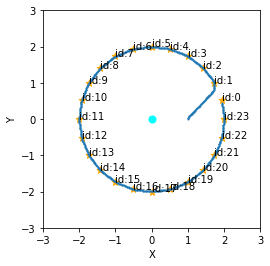

['ZO', 'P0', 'P1']


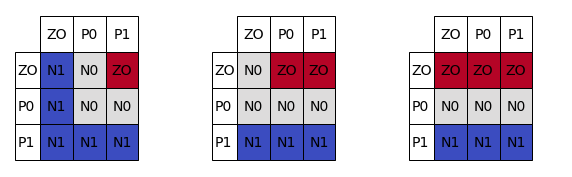

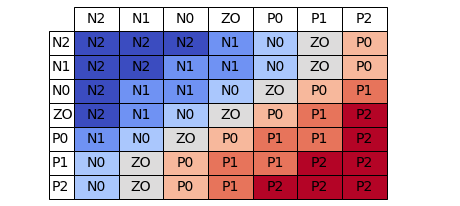

In [10]:
#最後の世代の個体ゲット
pop = res.pop

#個体を選ぶ
pop_no = pop_No_update(res,None)#Noneで合計の距離最も短い個体
#pop_no = 0

#ファジィ制御更新
problem,Kis = fuzzy_control_new_set(problem,pop_no) #Noneでデフォルト
#problem.obj_control.fuzzy_produce(Kis,None)
#出力結果
drive_result = 1
obj_func_value_result = 0
rule_result=1
member_result=0
if drive_result:
    fpos = [1,0,math.pi/2]
    lms = np.array([[0,0],[0,0.5],[-0.5,0.5],[-0.5,-0.5],[0.5,-0.5],[0.5,0.5]])
    #lms = np.array([[0,0],[0,1],[0,2]])
    lms = np.array(lms_list)
    datas = drive_test(problem,Kis,fpos,lms,65)
if obj_func_value_result:
    print_obj_func(problem,res,1)
if rule_result or member_result:
    print_result(member_result,rule_result,problem.obj_control,pop[pop_no],Kis)

In [11]:
x_poses = datas[0]
y_poses = datas[1]

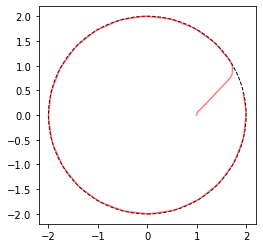

In [12]:
g = plt.subplot()
g.set_aspect('equal')
circle = patches.Circle(xy=(0, 0), radius=2, ec="black",fc="none", linestyle = "dashed")

#add_patch関数は、本当はグラフ上に図を描写するためのコマンド
#このプログラムでは、正確には円関数を描写しているのではなく、
#空白のグラフに、円の図を置いているだけ
g.add_patch(circle)
plt.plot(x_poses,y_poses,color="red",alpha=0.5)
plt.show()

In [13]:
X, F = res.opt.get("X", "F")
hist = res.history
print(len(hist))

10


In [14]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:
    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

In [15]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

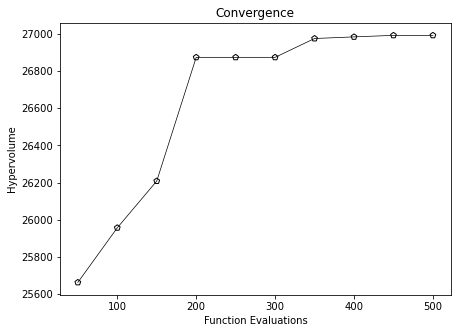

In [16]:
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array([30,30,30]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

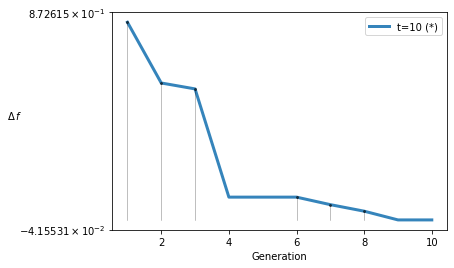

In [17]:
from pymoo.util.running_metric import RunningMetricAnimation

running = RunningMetricAnimation(delta_gen=10,
                        n_plots=3,
                        key_press=False,
                        do_show=True)

for algorithm in res.history[:15]:
    running.update(algorithm)

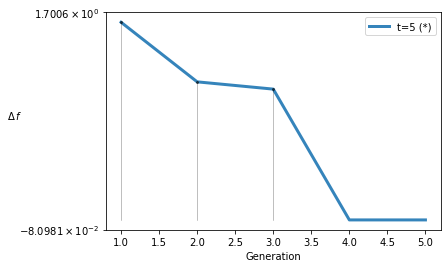

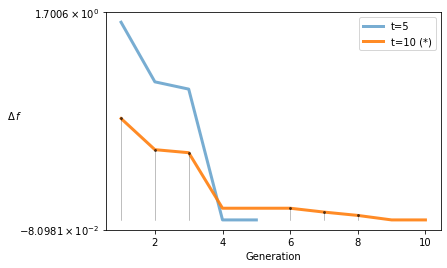

In [18]:
from pymoo.util.running_metric import RunningMetric

running = RunningMetricAnimation(delta_gen=5,
                        n_plots=10,
                        key_press=False,
                        do_show=True)

for algorithm in res.history:
    running.update(algorithm)

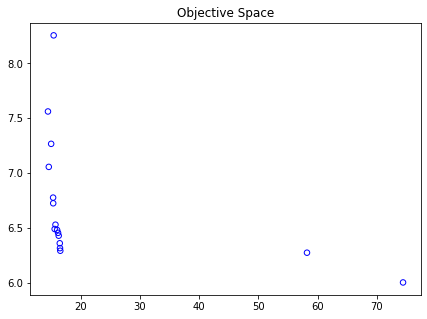

In [19]:
#https://pymoo.org/getting_started/part_3.html

F = res.F
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 1], F[:, 2], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [20]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

Scale f1: [6.8, 11.8]
Scale f2: [14.503958314471328, 74.40046437025104]


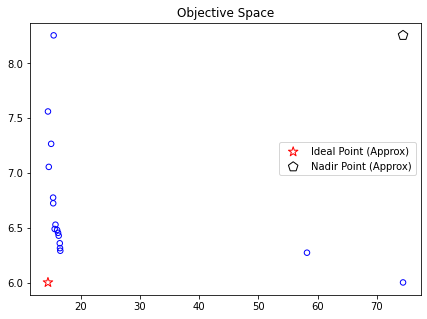

In [21]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 1], F[:, 2], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[1], approx_ideal[2], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[1], approx_nadir[2], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()

Scale f1: [0.0, 1.0]
Scale f2: [0.0, 1.0]


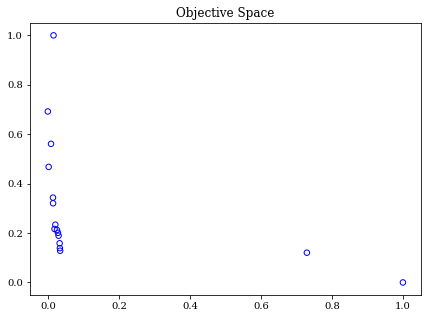

In [35]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

fl = nF.min(axis=0)
fu = nF.max(axis=0)
print(f"Scale f1: [{fl[1]}, {fu[1]}]")
print(f"Scale f2: [{fl[2]}, {fu[2]}]")

plt.figure(figsize=(7, 5))
plt.scatter(nF[:, 1], nF[:, 2], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [38]:
i

2

In [34]:
weights = np.array([0.8, 0.1,0.1])
from pymoo.decomposition.asf import ASF

decomp = ASF()
i = decomp.do(nF, 1/weights).argmin()

Best regarding ASF: Point 
i = 2
F = [ 6.95       15.37350997  6.77736708]


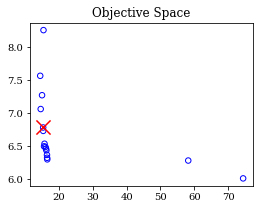

In [39]:
print("Best regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(4, 3))
plt.scatter(F[:, 1], F[:, 2], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 1], F[i, 2], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()

In [25]:
from pymoo.mcdm.pseudo_weights import PseudoWeights

i = PseudoWeights(weights).do(nF)

Best regarding Pseudo Weights: Point 
i = 6
F = [ 6.85       15.04274203  7.26692075]


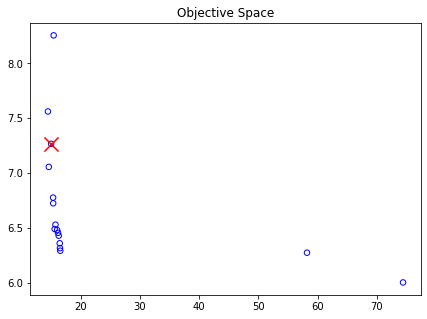

In [26]:
print("Best regarding Pseudo Weights: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 1], F[:, 2], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 1], F[i, 2], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()

In [27]:
##memo
#print(res.F) #ランク1のみの評価
#print(res.X) #ランク1のみの個体

#1世代1世代の歴史が詰まっている (res.histroy[x]はresと使い方は同じ)
#res.history[29].pop[0].get("X")

#個体選び(この場合は距離が短いやつ)
#pop_no=np.argmin(np.sum(res.F,1))
#pop_no = np.argmin(res.F[:,1])



In [28]:
#使わない関数
#ms = lms_produce(1,1)
#Kis = GApara_use(ga,design_variable,1)
def GApara_use(ga,design_variable,NO):
    one_ptype = []
    plus = 0
    for variable in design_variable:
        individual_Ptype = 0
        power = variable[0]-1
        for j in range(variable[0]):
            individual_Ptype+=((ga.code_max+1)**power)*ga.gtype_pop[NO][j+plus]
            power -=1
        plus += variable[0]
        individual_Ptype = variable[1]+individual_Ptype*(variable[2]-variable[1])/((ga.code_max+1)**variable[0])
        one_ptype.append(individual_Ptype)
        
    return one_ptype

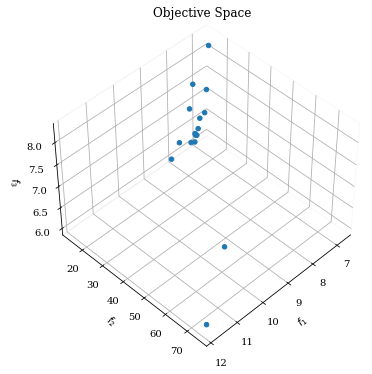

In [29]:
# 3次元(非優越解のみ)
# 結果の可視化
ps = problem.pareto_set(use_cache=False, flatten=False)
pf = problem.pareto_front(use_cache=False, flatten=False)
plot = Scatter(title = "Objective Space")
plot.add(res.F)
if pf is not None:
    plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.show()

In [30]:
import matplotlib.pyplot as plt
import numpy as np

from pymoo.core.individual import Individual
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX


def show(eta_cross):
    problem = Problem(n_var=1, xl=0.0, xu=1.0)

    a, b = Individual(X=np.array([0.2])), Individual(X=np.array([0.8]))

    parents = [[a, b] for _ in range(5000)]

    off = SBX(prob=0.9, prob_var=0.5, eta=eta_cross).do(problem, parents)
    Xp = off.get("X")

    plt.hist(Xp, range=(0, 1), bins=200, density=True, color="red")
    plt.show()

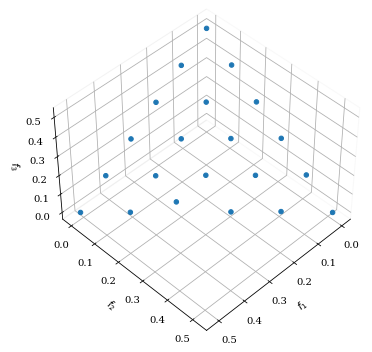

In [32]:
from pymoo.algorithms.moo.nsga3 import NSGA3


from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=5)

# create the algorithm object
algorithm = NSGA3(pop_size=33,
                  ref_dirs=ref_dirs)

# execute the optimization
res = minimize(get_problem("dtlz1"),
               algorithm,
               seed=1,
               termination=('n_gen', 600))

Scatter().add(res.F).show()

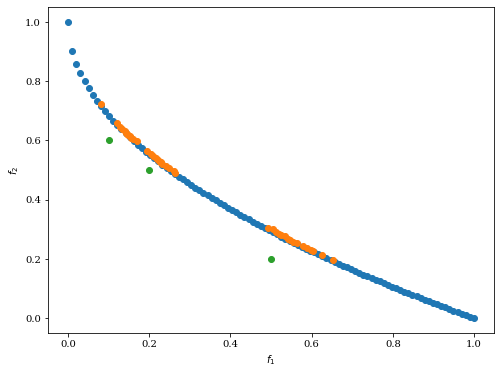

In [33]:
import numpy as np

from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt1", n_var=30)
pf = problem.pareto_front()

# Define reference points
ref_points = np.array([[0.5, 0.2], [0.1, 0.6],[0.2, 0.5]])

# Get Algorithm
algorithm = RNSGA2(
    ref_points=ref_points,
    pop_size=40,
    epsilon=0.01,
    normalization='front',
    extreme_points_as_reference_points=False,
    weights=np.array([0.5, 0.5]))

res = minimize(problem,
               algorithm,
               save_history=True,
               termination=('n_gen', 100),
               seed=2,
               pf=pf,
               disp=False)


Scatter().add(pf, label="pf").add(res.F, label="F").add(ref_points, label="ref_points").show()